#  Recommender Systems 

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from operator import itemgetter

# Users

We recommended new games based on the similarity between users therefore we use both train and test data for making our model


In [2]:
df1=pd.read_csv("train.csv")
df2=pd.read_csv("test.csv")
df1['historical_games']=[list(map(str, i.split(" "))) for i in df1['historical_games'] ]
df2['historical_games']=[list(map(str, i.split(" "))) for i in df2['historical_games'] ]
df1=df1.drop(columns=['next_game'])
#Combining both datasets
df=pd.concat([df1, df2],ignore_index=True)

In [3]:
def save_into_csv(df,recom):
  Predication=pd.DataFrame(df['id'])
  Predication['next_game']=0
  for i in range(len(recom)):
    x = [str(x) for x in recom[i]]
    Predication['next_game'][i]= " ".join(x)
  Predication.to_csv("Predication.csv",index=False) 

# Popularity model
In this approach we recommend games that are most popular (downloaded) to every body 

In [4]:
#How many time every game has been downloaded
def count_download(df):  
    downloaddict=dict()
    for i in df['historical_games']:
      for j in i:
        if j in downloaddict:
          downloaddict[j]=downloaddict[j]+1
        else:
          downloaddict[j]=1
    N = len(downloaddict)
    res = dict(sorted(downloaddict.items(), key = itemgetter(1), reverse = True)[:N])
    return res

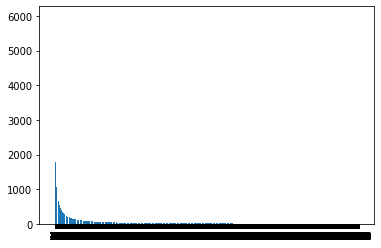

In [58]:
count_dict=count_download(df)
plt.bar(*zip(*count_dict.items()))
plt.show()


In [6]:
#giving the most popular games as recommended game
def Poularity(df):
  keysList = list(count_dict.keys())
  R=[]
  for i in df['id']:
    R.append(keysList[:5])
  save_into_csv(df,R) 

Poularity(df)

# Collaborative filtering
In this approach we recommend games to users with similar taste

In [28]:
data_list = []
for i in range(len(df)):
  dic=dict()
  for j in (df['historical_games'][i]):
    if j in dic:
      dic[j]=dic[j]+1
    else:
      dic[j]=1
  for key in dic:
    #only consider games that are played more than 100 times
    if count_dict[key]>100:
        data_list.append((df['id'][i],key,dic[key]))
Download_users = pd.DataFrame (data_list,columns=['user','item','download'])

In [ ]:
game_download_pivot = Download_users.pivot_table(values = 'download', index = 'item', columns = 'user')  

# Replace NaNs with 0s
game_download_pivot.fillna(0, inplace = True)

# Display first few rows and columns of game and ratings pivot table
game_download_pivot

In [ ]:
game_titles = game_download_pivot.index

# Define correlation matrix to get correlation between game
corr_matrix = np.corrcoef(game_download_pivot)

# Display correlation matrix
corr_matrix

In [31]:
def recommender(game_names):  
    # Initialize recommendations output length of number of game
    recommendations = np.zeros(corr_matrix.shape[0])
    # Loop through the game titles that the user has rated
    for game in game_names:
        # Sum the correlations
        recommendations = recommendations + corr_matrix[list(game_titles).index(game)]
    # Convert recommendations into dataframe
    recommendations_df = pd.DataFrame({
            'Title': game_titles,
            'Recommendation': recommendations})
    # Remove game titles that the user has already rated
    recommendations_df = recommendations_df[~(recommendations_df.Title.isin(game_names))]
    # Sort from most correlated to least correlated
    recommendations_df = recommendations_df.sort_values(by=['Recommendation'], ascending = False)
    return recommendations_df

In [34]:

recom=[]
for user in df2['id']:
  # Get list of games that user has played
  user_movies = Download_users[Download_users.user == user].item.tolist()  
  # Get list of recommendations
  recommendations = recommender(user_movies)
  # Append top 5 recommendations
  recom.append(recommendations.Title.head(5).values)

In [ ]:
save_into_csv(df,recom)

# Combination model 
In this approach, we use both model to recommend games

In [ ]:
recom1=[]
for user in df2['id']:
  # Get list of games that user has played
  user_movies = Download_users[Download_users.user == user].item.tolist()  
  # Get list of recommendations
  recommendations = recommender(user_movies)
  # Append top 5 recommendations
  recom1.append(recommendations.Title.head(10).values)

In [54]:
keysList = list(count_dict.keys())
Re=[]
for i in range(len(df2['id'])):
  X=[]
  #If the game is recommended by both models definitely recommended 
  X=(np.intersect1d(recom1[i], keysList[:10]))
  X=X.tolist()

  if len(X)>5:
    Re.append(X[:5])
  #if there is less than 5 recommended recommended base on similarity
  if len(X)<=5:
    while len(X)<5: 
      for x in recom1[i]:
        if x not in X:
          X.append(x)
          if len(X)==5:
            break
    Re.append(X)

In [ ]:
save_into_csv(df,Re)